### I - Introduction

In this project, I aimed to predict the prices of second-hand cars based on various features present in the dataset, whether they are numerical or categorical in nature. These features included the year of manufacture, the price of the car when it was new, the number of kilometers it has been driven, the type of fuel it uses, seller type, owner, and the transmission type. 

To accomplish this, I used several regression techniques: 
- Linear Regression
- Lasso
- Ridge
- ElasticNet
- Random Forests
- Decision Tree Regressor
- XGBoost Regressor


I performed the **prediction** task **twice**, once using *polynomial features* and another without them. Interestingly, I found that some models **without polynomial features performed better in cross-validation** than the one that utilized them.

### II - Table of content

- [I - Introduction](#i---introduction)
- [II - Table of content](#ii---table-of-content)
- [III - Exploratory Data Analysis](#iii---exploratory-data-analysis)
- [IV -  Train the model](#iv---train-the-model)
  - [A - Without Polynomial Features](#a---without-polynomial-features)
  - [B - With Polynomial Features](#b---with-polynomial-features)
- [V - Comparison of Regression Models](#v---comparison-of-regression-models)
- [VI - Conclusions](#vi---conclusions)

### III - Exploratory Data Analysis

In [54]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the dataset
df = pd.read_csv('car data.csv')
df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


It's important to see the correlation between the target and the independent variables. 

According to what we see below, seems like year and selling price have a non-linear relationship, but the other graphs look more linear. 

We will figure it out if the Polynomial Features will improve the prediction. 

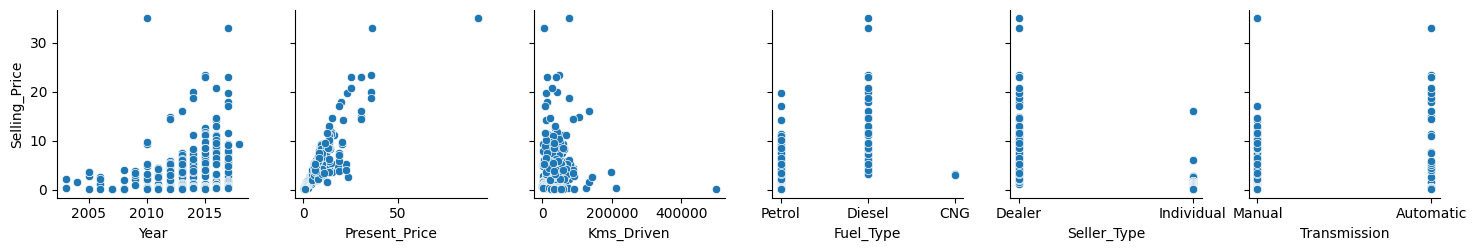

In [55]:
sns.pairplot(df, x_vars=['Year', 'Present_Price', 'Kms_Driven', 'Fuel_Type', 'Seller_Type', 'Transmission'], y_vars=['Selling_Price'])
plt.show()

We see the distribution of the target and there are 2 outliers. They don't seem to be noise, errors or extreme outliers, just atypical values that can help the model predict in the range of those atypical values. 

If we eliminate them obviously the prediction will have a better r2 score, but it's because the linearity will increase and, thus, will improve the prediction.

<Axes: xlabel='Selling_Price', ylabel='Count'>

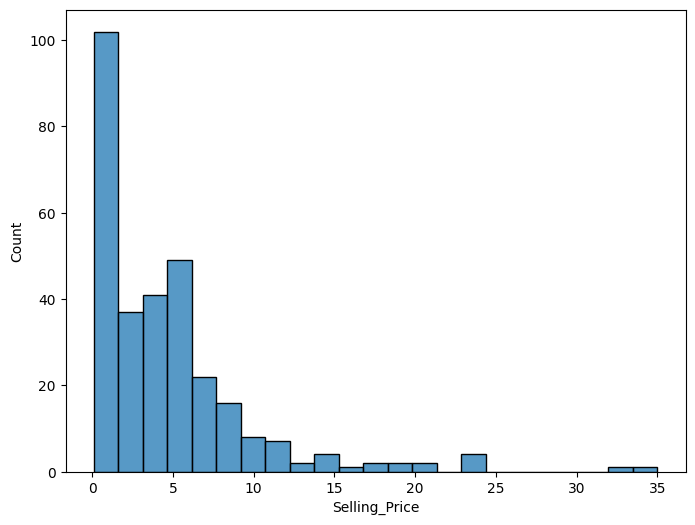

In [56]:
f, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df['Selling_Price'], ax=ax)

We check the type of value of each column and if there are null values in the dataset. 

In [57]:
# df['Seller_Type'] = df['Seller_Type'].astype('category')
# df['Fuel_Type'] = df['Fuel_Type'].astype('category')
# df['Transmission'] = df['Transmission'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


We need to see the **descriptive statistics** of the columns

The standard deviation of Kms_Driven is very high, it's better if we apply a scaler before training the model

In [58]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


There are few **outliers**, so the standard scaler could be a good solution to solve the std

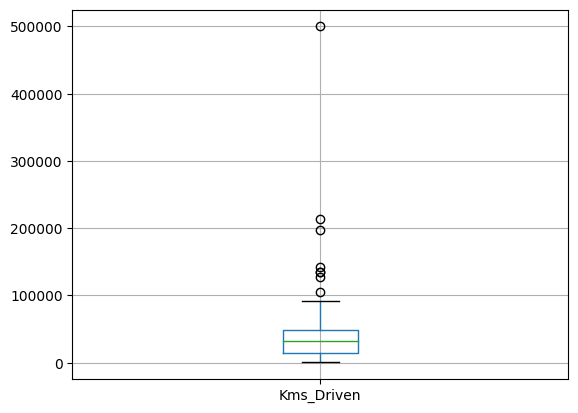

In [59]:
df.boxplot(column='Kms_Driven')
plt.show()

There are only 3 different values in the Owner column and 2 of them are outliers, this might be more noise than useful information.

We will figure it out later.

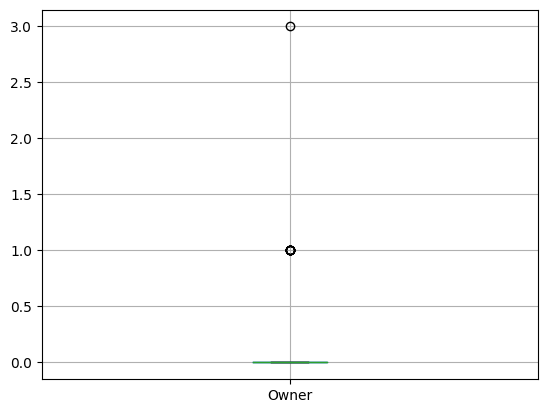

In [60]:
df.boxplot(column='Owner')
plt.show()

We need to see the **correlation** between the target and the independent variables to have a better decision of what to do with the columns

We use the method corr() to see their relationships.

Kms_Driven has a low correlation with the target but has a better relationship with Year and Present_Price. These features are really important so we will keep the Kms_Driven values.


C:\Users\ockda\AppData\Local\Temp\ipykernel_12868\3645667459.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), square=True, annot=True, cbar=True, ax=ax)


<Axes: >

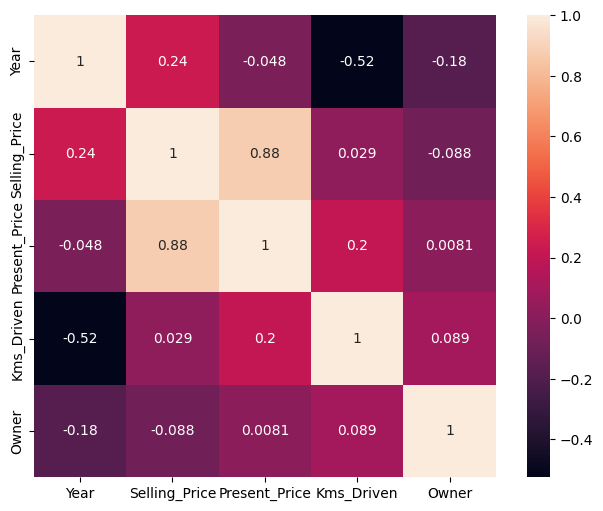

In [61]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), square=True, annot=True, cbar=True, ax=ax)

In [62]:
df.corr()

C:\Users\ockda\AppData\Local\Temp\ipykernel_12868\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Year,Selling_Price,Present_Price,Kms_Driven,Owner
Year,1.000000,0.236141,-0.047584,-0.524342,-0.182104
Selling_Price,0.236141,1.000000,0.878983,0.029187,-0.088344
Present_Price,-0.047584,0.878983,1.000000,0.203647,0.008057
Kms_Driven,-0.524342,0.029187,0.203647,1.000000,0.089216
Owner,-0.182104,-0.088344,0.008057,0.089216,1.000000


If we are talking about the price of a car, it is important to consider the type of seller. 

They might have **different kind of evaluation** to define the price.

In [63]:
df.groupby(['Seller_Type']).count()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Transmission,Owner
Seller_Type,,,,,,,,
Dealer,195,195,195,195,195,195,195,195
Individual,106,106,106,106,106,106,106,106


It's really important the transmission to define the **price of a car**.

We will **keep the column** as well.

In [64]:
df.groupby(['Transmission']).count()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Owner
Transmission,,,,,,,,
Automatic,40,40,40,40,40,40,40,40
Manual,261,261,261,261,261,261,261,261


There are 98 different names of cars in a dataset of a total of 301 names.

This **doesn't help to train** the model because there are no so much variety of values.

In [65]:
df.groupby(['Car_Name']).count()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
Car_Name,,,,,,,,
800,1,1,1,1,1,1,1,1
Activa 3g,2,2,2,2,2,2,2,2
Activa 4g,1,1,1,1,1,1,1,1
Bajaj ct 100,1,1,1,1,1,1,1,1
Bajaj Avenger 150,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
sx4,6,6,6,6,6,6,6,6
verna,14,14,14,14,14,14,14,14
vitara brezza,1,1,1,1,1,1,1,1


The **correlations** of Owner and all the other variables are **less than 0.2**. If it's not helping to predict the price we should delete it.

In [66]:
df.groupby(['Owner']).count()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission
Owner,,,,,,,,
0,290,290,290,290,290,290,290,290
1,10,10,10,10,10,10,10,10
3,1,1,1,1,1,1,1,1


After looking at the columns, the descriptive statistics, the boxplots, and the correlation, we should **delete the column Owner.**

The other variables are useful to predict the price and we will store them in a new variable X_full and the target in y. 

In [67]:
X_full = df.drop(['Owner','Car_Name'], axis=1)

X_full.drop(['Selling_Price'], axis=1, inplace=True)
X_full

,Year,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission
0,2014,5.59,27000,Petrol,Dealer,Manual
1,2013,9.54,43000,Diesel,Dealer,Manual
2,2017,9.85,6900,Petrol,Dealer,Manual
3,2011,4.15,5200,Petrol,Dealer,Manual
4,2014,6.87,42450,Diesel,Dealer,Manual
...,...,...,...,...,...,...
296,2016,11.60,33988,Diesel,Dealer,Manual
297,2015,5.90,60000,Petrol,Dealer,Manual
298,2009,11.00,87934,Petrol,Dealer,Manual
299,2017,12.50,9000,Diesel,Dealer,Manual


### IV - Train the Model
#### A - Without Polynomial Features

In [68]:
# We apply get_dummies to do One Hot Encoder to the columns Fuel_Type, Seller_Type and Transmission
one_hot = pd.get_dummies(df[['Fuel_Type','Seller_Type','Transmission']])

# We select the numerical columns of the dataset
num_colums = df.loc[:,['Year','Present_Price','Kms_Driven']]

# The final amount of data before training the model
X_full = pd.concat([num_colums,one_hot], axis=1)
y = df.Selling_Price

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Apply StandardScaler to the numeric columns
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

# Split the variables between train and test
X_train, X_test, y_train, y_test = train_test_split(X_full_scaled, y, train_size=0.7, random_state=0)

To have a better prediction we get the best alpha for Lasso, Ridge and Elastic Net

In [70]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

# We get the best alpha for Lasso, Ridge and Elasticnet
reg_Lasso = LassoCV(max_iter = 10000, cv = 20, random_state=0).fit(X_train, y_train)
reg_Ridge = RidgeCV(cv = 20).fit(X_train, y_train)
reg_Elastic = ElasticNetCV(max_iter = 10000, cv = 20, random_state=0).fit(X_train, y_train)

# We look at the results to see if the values are ok 
print('Alpha for Lasso:',reg_Lasso.alpha_)
print('Alpha for Ridge',reg_Ridge.alpha_)
print('Alpha for ElasticNet',reg_Elastic.alpha_)

Alpha for Lasso: 0.18437782576946402
Alpha for Ridge 10.0
Alpha for ElasticNet 0.14886729294676695


In [71]:
# Import models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import time

# We define the models and save it to a variable we are gonna use in a list
cars_lr = LinearRegression()
cars_ls = Lasso(max_iter= 10000,alpha=reg_Lasso.alpha_)
cars_rg = Ridge(max_iter= 10000,alpha=reg_Ridge.alpha_)
cars_en = ElasticNet(max_iter= 10000, alpha=reg_Elastic.alpha_)
cars_XG = XGBRegressor()
cars_RFR = RandomForestRegressor(random_state=0)
cars_DTR = DecisionTreeRegressor(random_state=0)

# We store the models in a list
models = [(cars_lr, 'Linear Regression'),
           (cars_ls, 'Lasso'),
           (cars_rg, "Ridge Regression"),
           (cars_en, "Elastic Net"),
           (cars_XG, "XGBoost Regressor"),
           (cars_RFR, "Random Forest Regressor"),
           (cars_DTR, "Decision Tree Regressor")]

# Just store the names
models_names = ['Linear Regression','Lasso','Ridge Regression','Elastic Net','XGBoost Regressor','Random Forest Regressor','Decision Tree Regressor']

r2 = []
mse = []
training_time = []

# We evaluate each model and save the r2, mean squared error, cross-validation and the training time in 4 lists
for model in models:
    start_time = time.time()                        #start counting the time it takes to train
    model[0].fit(X_train, y_train)
    training_time.append(time.time()-start_time)    #it gets the time that took to train the model
    r2.append(round(r2_score(y_test, model[0].predict(X_test)),3))
    mse.append(round(mean_squared_error(y_test, model[0].predict(X_test)),3))

# We store the results in a DataFrame to evaluate 
result_without_poly = pd.DataFrame({'Model':models_names, 'R2 Score': r2, 'MSE': mse, 
                                    'Training time': training_time}).sort_values('R2 Score', ascending = False)
result_without_poly.reset_index(drop = True,inplace=True)

#### B - With Polynomial Features

In [72]:
# We apply get_dummies to do One Hot Encoder to the columns Fuel_Type, Seller_Type and Transmission
one_hot = pd.get_dummies(df[['Fuel_Type','Seller_Type','Transmission']])

# We select the numerical columns of the dataset
num_colums = df.loc[:,['Year','Present_Price','Kms_Driven']]

# The final amount of data before training the model
X_full = pd.concat([num_colums,one_hot], axis=1)
y = df.Selling_Price

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

# Apply StandardScaler to the numeric columns
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

# Split the variables between train and test
X_train, X_test, y_train, y_test = train_test_split(X_full_scaled, y, train_size=0.7, random_state=0)

poly_features = PolynomialFeatures(degree=2)

# transforms the existing features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

To have a better prediction we get the best alpha for Lasso, Ridge 

In [74]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

# We get the best alpha for Lasso, Ridge and Elasticnet
reg_Lasso = LassoCV(max_iter = 10000, cv = 20, random_state=0).fit(X_train_poly, y_train)
reg_Ridge = RidgeCV(cv = 20).fit(X_train_poly, y_train)
reg_Elastic = ElasticNetCV(max_iter = 10000, cv = 20, random_state=0).fit(X_train_poly, y_train)

# We look at the results to see if the values are ok 
print('Alpha for Lasso:',reg_Lasso.alpha_)
print('Alpha for Ridge',reg_Ridge.alpha_)
print('Alpha for ElasticNet',reg_Elastic.alpha_)

Alpha for Lasso: 0.10768741976347604
Alpha for Ridge 10.0
Alpha for ElasticNet 0.0932306266263747


In [75]:
# Import models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import time

# We define the models and save it to a variable we are gonna use in a list
cars_lr = LinearRegression()
cars_ls = Lasso(max_iter= 10000,alpha=reg_Lasso.alpha_)
cars_rg = Ridge(max_iter= 10000,alpha=reg_Ridge.alpha_)
cars_en = ElasticNet(max_iter= 10000, alpha=reg_Elastic.alpha_)
cars_XG = XGBRegressor()
cars_RFR = RandomForestRegressor(random_state=0)
cars_DTR = DecisionTreeRegressor(random_state=0)

# We store the models in a list
models = [(cars_lr, 'Linear Regression'),
           (cars_ls, 'Lasso'),
           (cars_rg, "Ridge Regression"),
           (cars_en, "Elastic Net"),
           (cars_XG, "XGBoost Regressor"),
           (cars_RFR, "Random Forest Regressor"),
           (cars_DTR, "Decision Tree Regressor")]

# Just store the names
models_names = ['Linear Regression','Lasso','Ridge Regression','Elastic Net','XGBoost Regressor','Random Forest Regressor','Decision Tree Regressor']

r2 = []
mse = []
training_time = []

# We evaluate each model and save the r2, mean squared error, cross-validation and the training time in 4 lists
for model in models:
    start_time = time.time()                        #start counting the time it takes to train
    model[0].fit(X_train_poly, y_train)
    training_time.append(time.time()-start_time)    #it gets the time that took to train the model
    r2.append(round(r2_score(y_test, model[0].predict(X_test_poly)),3))
    mse.append(round(mean_squared_error(y_test, model[0].predict(X_test_poly)),3))

# We store the results in a DataFrame to evaluate
result_with_poly = pd.DataFrame({'Model':models_names, 'R2 Score': r2, 'MSE': mse, 
                                    'Training time': training_time}).sort_values('R2 Score', ascending = False)
result_with_poly.reset_index(drop = True,inplace=True)

### V - Comparison of Regression Models

In [76]:
result_without_poly

,Model,R2 Score,MSE,Training time
0,XGBoost Regressor,0.914,2.574,0.088089
1,Random Forest Regressor,0.914,2.582,0.333053
2,Decision Tree Regressor,0.913,2.605,0.002001
3,Linear Regression,0.852,4.431,0.001066
4,Ridge Regression,0.841,4.755,0.001004
5,Lasso,0.831,5.068,0.001997
6,Elastic Net,0.828,5.152,0.003012


In [77]:
result_with_poly

,Model,R2 Score,MSE,Training time
0,Lasso,0.963,1.092,0.005002
1,Linear Regression,0.957,1.291,0.010998
2,Elastic Net,0.948,1.545,0.014000
3,Ridge Regression,0.944,1.681,0.002000
4,Random Forest Regressor,0.918,2.463,0.893861
5,XGBoost Regressor,0.911,2.648,0.168039
6,Decision Tree Regressor,0.826,5.197,0.006001


### VI -  Conclusions
- Lasso would be chosen including Polynomial Features for its high R2 Score and low mean squared error.
- It's important to include categorical variables in the training, which is why One Hot Encoder is applied.
- By applying Polynomial Features, most models improved their mean squared error, which means that the predictions have a better response due to the low error.
- Linear Regression would be the second best option, as its R2 Score and MSE are slightly worse than the Lasso model.
- In this case, Lasso also has a low training time, which would be beneficial for saving resources.
